In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("../..")
print("at directory:", os.getcwd())

at directory: /Users/wilka/git/research/jaxneurorl/projects/humansf
changing to root directory
at directory: /Users/wilka/git/research/jaxneurorl


In [3]:
import jax
import jax.numpy as jnp
import functools

import projects.humansf.trainer_housemaze as trainer
from projects.humansf import housemaze_env as maze
from projects.humansf.housemaze import utils
from projects.humansf.housemaze import renderer

/Users/wilka/miniforge3/envs/jaxneurorl/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:145: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)


In [4]:
group_set, env_params = trainer.load_env_params(
    num_groups=3,
    file='projects/humansf/housemaze_list_of_groups.npy',
)
test_env_params = env_params.replace(training=False)
jax.tree_map(lambda x:x.shape, env_params.reset_params)

ResetParams(map_init=MapInit(grid=(4, 13, 13, 1), agent_pos=(4, 2), agent_dir=(4,)), train_objects=(4, 3), test_objects=(4, 3), starting_locs=(4, 3, 10, 2), curriculum=(4,))

In [5]:
task_objects = group_set.reshape(-1)
task_objects

array([26, 40, 47, 43, 25, 30], dtype=int32)

In [8]:
import matplotlib.pyplot as plt

image_dict = utils.load_image_dict('projects/humansf/housemaze/image_data.pkl')

def render_timestep(timestep):
    image = renderer.create_image_from_grid(
        timestep.state.grid,
        timestep.state.agent_pos,
        timestep.state.agent_dir,
        image_dict)
    plt.imshow(image)
    plt.show()

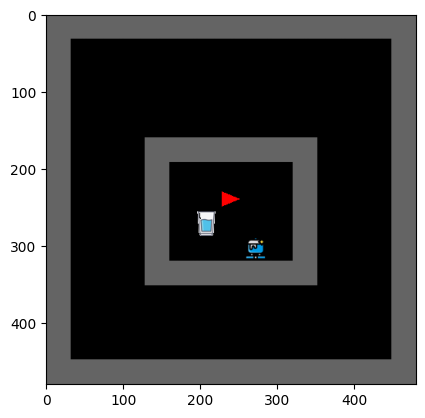

In [9]:
seed = 6
rng = jax.random.PRNGKey(seed)

task_runner = maze.TaskRunner(
    task_objects=task_objects)
env = maze.HouseMaze(
    task_runner=task_runner,
    num_categories=len(image_dict['keys']),
)
env = utils.AutoResetWrapper(env)

reset_timestep = env.reset(rng, env_params)
render_timestep(reset_timestep)


In [10]:
import hydra
from omegaconf import OmegaConf
with hydra.initialize(
    version_base=None,
    config_path='../../projects/humansf/configs'):
    config = hydra.compose(
      config_name='ql_keyroom')
    config = OmegaConf.to_container(config)
config

{'ALG': 'qlearning',
 'NUM_SEEDS': 1,
 'SEED': 1,
 'MAX_EPISODE_LOG_LEN': 40,
 'NUM_ENVS': 32,
 'EVAL_STEPS': 100,
 'EVAL_EPISODES': 100,
 'LEARNER_LOG_PERIOD': 500,
 'LEARNER_EXTRA_LOG_PERIOD': 5000,
 'EVAL_LOG_PERIOD': 25,
 'EVAL_LOG_PERIOD_ACTOR': 0,
 'GRADIENT_LOG_PERIOD': 5000,
 'AGENT_HIDDEN_DIM': 32,
 'NUM_EMBED_LAYERS': 0,
 'NUM_GRID_LAYERS': 1,
 'NUM_ENCODER_LAYERS': 2,
 'IMAGE_HIDDEN': 256,
 'ENCODER_INIT': 'word_init',
 'AGENT_RNN_DIM': 256,
 'BUFFER_SIZE': 50000,
 'BUFFER_BATCH_SIZE': 32,
 'SAMPLE_LENGTH': 40,
 'LEARNING_STARTS': 10000,
 'TRAINING_INTERVAL': 10,
 'FIXED_EPSILON': 2,
 'TOTAL_TIMESTEPS': 10000000.0,
 'EPSILON_START': 1.0,
 'EPSILON_FINISH': 0.1,
 'EPSILON_ANNEAL_TIME': 500000.0,
 'MAX_GRAD_NORM': 80,
 'TARGET_UPDATE_INTERVAL': 1000,
 'LR': 0.001,
 'LR_LINEAR_DECAY': False,
 'EPS_ADAM': 1e-05,
 'GAMMA': 0.99,
 'hydra/output_subdir': None,
 'hydra/hydra_logging': 'disabled',
 'hydra/job_logging': 'disabled',
 'user': {'ENTITY': 'wcarvalho92',
  'SLURM_PARTITION

In [11]:
config['TOTAL_TIMESTEPS'] = 1e3

In [12]:
import functools
from agents import value_based_basics as vbb
from projects.humansf import qlearning
from projects.humansf import networks

make_train = functools.partial(
          vbb.make_train,
          make_agent=functools.partial(
             qlearning.make_agent,
             ObsEncoderCls=networks.HouzemazeObsEncoder,
             ),
          make_optimizer=qlearning.make_optimizer,
          make_loss_fn_class=qlearning.make_loss_fn_class,
          make_actor=qlearning.make_actor,
      )

train_fn = make_train(
      config=config,
      env=env,
      train_env_params=env_params,
      test_env_params=test_env_params,
      #ObserverCls=observer_class,
      )
train_vjit = jax.jit(jax.vmap(train_fn))

rng = jax.random.PRNGKey(config["SEED"])
rngs = jax.random.split(rng, config["NUM_SEEDS"])
outs = jax.block_until_ready(train_vjit(rngs))


Total number of params: 2,234,944
	observation_encoder: 1,576,512
	rnn: 525,312
	q_fn: 133,120
TRAINING
